# Time Series Forecasting with a Practical Example using FB Prophet

Facebook developed an open sourcing Prophet, a forecasting tool available in both Python and R. It provides intuitive parameters which are easy to tune. Even someone who lacks deep expertise in time-series forecasting models can use this to generate meaningful predictions for a variety of problems in business scenarios.

The Prophet Forecasting Model

The Prophet uses a decomposable time series model with three main model components: trend, seasonality, and holidays. 
    They are combined in the following equation:

        y(t)= g(t) + s(t) + h(t) + εt

        g(t): piecewise linear or logistic growth curve for modeling non-periodic changes in time series
        s(t): periodic changes (e.g. weekly/yearly seasonality)
        h(t): effects of holidays (user provided) with irregular schedules
        εt: error term accounts for any unusual changes not accommodated by the model
            
Using time as a regressor, Prophet is trying to fit several linear and non linear functions of time as components. Modeling seasonality as an additive component is the same approach taken by exponential smoothing in Holt-Winters technique . Prophet is framing the forecasting problem as a curve-fitting exercise rather than looking explicitly at the time based dependence of each observation within a time series.

useful links:
    
https://towardsdatascience.com/a-quick-start-of-time-series-forecasting-with-a-practical-example-using-fb-prophet-31c4447a2274
    
https://github.com/facebook/prophet

[Предсказываем будущее с помощью библиотеки Facebook Prophet](https://habrahabr.ru/company/ods/blog/323730/)

https://nbviewer.jupyter.org/github/miptgirl/habra_materials/blob/master/prophet/habra_data.ipynb

Библиотека prophet позволяет быстро и достаточно качественно автоматически строить прогнозы временныз рядов. Подробно про теорию работы можно почитать в замечательной статьей по ссылке выше, а сейчас посмотрим на практике, как она работает

Box–Cox transformation

transformation makes the data more normal distribution-like, improves the validity of measures of association such as the Pearson correlation between variables and for other data stabilization procedures. 

The one-parameter Box–Cox transformations are defined as

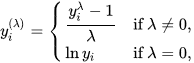

https://en.wikipedia.org/wiki/Power_transform

In [31]:
import pandas as pd
import numpy as np
import calendar

from fbprophet import Prophet
from sklearn import metrics
from sklearn.preprocessing import MaxAbsScaler
from scipy import stats

import matplotlib.pyplot as plt
from plotly import graph_objs as go
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

# Import and suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [32]:
''' VISUALISATION '''


def PlotMovingAverage(series_,
                      window_,
                      title_='',
                      plot_intervals_=False,
                      scale_=1.96,
                      plot_anomalies_=False):
    ''' Visualization of the TimeSerie with moving average window and anomalies. '''
    '''
        series_ - dataframe with timeseries
        window_ - rolling window size 
        plot_intervals_ - show confidence intervals
        plot_anomalies_ - show anomalies 

    '''
    rolling_mean = series_.rolling(window=window_).mean()

    plt.figure(figsize=(15, 5))
    plt.xticks(rotation='vertical')
    plt.title(title_ + 'Moving average\n window size = {}'.format(window_))
    plt.plot(
        rolling_mean,
        color='lightblue',
        linewidth=2,
        label='Rolling mean trend')

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    if plot_intervals_:
        mae = metrics.mean_absolute_error(series_[window_:],
                                          rolling_mean[window_:])
        deviation = np.std(series_[window_:] - rolling_mean[window_:])
        lower_bond = rolling_mean - (mae + scale_ * deviation)
        upper_bond = rolling_mean + (mae + scale_ * deviation)
        plt.plot(upper_bond, 'r--', label='Upper Bond / Lower Bond')
        plt.plot(lower_bond, 'r--')

        # а имея доверительные интервалы, можно искать аномальные значения
        if plot_anomalies_:
            anomalies = pd.DataFrame(
                index=series_.index, columns=series_.columns)
            anomalies[series_ < lower_bond] = series_[series_ < lower_bond]
            anomalies[series_ > upper_bond] = series_[series_ > upper_bond]
            plt.plot(anomalies, 'ro', markersize=10)

    plt.plot(
        series_[window_:],
        'green',
        marker='o',
        markerfacecolor='green',
        markersize=6,
        color='green',
        linewidth=2,
        label='Actual values')

    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()


def PlotProphetFact(series_, predictions_, ytitle_='', xtitle_=''):
    ''' Visualization of the TimeSerie with Actual and Forecast values and trand. '''
    '''
        series_ - dataframe with timeseries actual values
        predictions_ - dataframe with timeseries forecast

    '''

    trend = go.Scatter(
        name='Trend',
        x=series_.index,
        y=series_.trend,
        marker=dict(color='lightblue'),
        mode='lines')

    forecast_upper = go.Scatter(
        name='upper_bond',
        x=series_.tail(predictions_).index,
        y=series_.tail(predictions_).yhat_upper,
        mode='lines',
        fill='tonexty',
        line=dict(color='lightpink'))
    forecast_lower = go.Scatter(
        name='lower_bond',
        x=series_.tail(predictions_).index,
        y=series_.tail(predictions_).yhat_lower,
        mode='lines',
        fill='tonexty',
        line=dict(color='lightpink'))
    forecast = go.Scatter(
        name='Forecast',
        x=series_.tail(predictions_).index,
        y=series_.tail(predictions_).yhat,
        mode='lines+markers',
        line=dict(color='red'))
    fact = go.Scatter(
        name='Actual values',
        x=series_.index,
        y=series_.y,
        marker=dict(color='green'),
        mode='lines+markers')
    forecast_tr = go.Scatter(
        name='Prophet',
        x=series_.index,
        y=series_.yhat,
        mode='lines',
        line=dict(color='pink'))

    cap = go.Scatter(
        name='100%',
        x=series_.index,
        y=series_.cap,
        marker=dict(color='black'),
        mode='markers')

    data = [trend, forecast_tr, fact,
            forecast]  #, forecast_lower,  forecast_upper]

    layout = go.Layout(
        yaxis=dict(title=ytitle_), title=xtitle_, showlegend=True)
    # xaxis={"title": "Year", "tickangle": 45},
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

In [33]:
''' FBPROPHET FORECAST '''


def InvBoxCox(y, lmbda):
    if lmbda == 0:
        return (np.exp(y))
    else:
        return (np.exp(np.log(lmbda * y + 1) / lmbda))


def BuildProphetModel(df_, scaler_, predictions_, test_=False, boxcox_=False):

    if test_:
        df_train_ = df_[:-predictions_]
    else:
        df_train_ = df_.copy()

    # BoxCox transformation
    if boxcox_:
        df_train_ = df_train_.copy().fillna(0)
        df_train_ = df_train_.set_index('ds')
        df_train_['y'], lmbda_prophet = stats.boxcox(df_train_['y'])
        df_train_.reset_index(inplace=True)

    # create and train prophet model
    model = Prophet(
        seasonality_mode='multiplicative',
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False)
    model.fit(df_train_)

    # forecast the future
    future = model.make_future_dataframe(periods=predictions_, freq='M')
    forecast = model.predict(future)

    # BoxCox invariation
    if boxcox_:
        for col in forecast.columns.tolist():
            # print(col)
            if col not in ['ds', 'floor', 'cap']:
                forecast[col] = InvBoxCox(forecast[col], lmbda_prophet)

    df_result_ = forecast.set_index('ds')[[
        'yhat', 'yhat_lower', 'yhat_upper', 'trend'
    ]].join(df_.set_index('ds'))

    # Normalization inverse transformation
    columns_ = df_result_.columns
    df_result_ = scaler_.inverse_transform(df_result_)
    df_result_ = pd.DataFrame(df_result_)
    df_result_.columns = columns_
    df_result_.reset_index(inplace=True)
    df_.reset_index(inplace=True)
    df_result_ = forecast[['ds']].join(df_result_).set_index('ds')

    df_result_['floor'], df_result_['cap'] = 0, 1

    return df_result_


def TransformPvToDf(pv_, col_name_, col_value_):
    ''' Transform pandas pivot table to regular dataframe. '''

    df_ = pv_.copy()
    df_.columns = df_.columns.droplevel(0)
    df_.columns.name = None
    df_ = df_.reset_index()

    dft_ = df_[df_[col_name_] == col_value_].T
    dft_.drop(dft_.index[[0, 1]], inplace=True)
    dft_.columns = ['y']
    # try:
    #    dft_ = dft_[:'2018-06']
    # except:
    #    print()
    return dft_


def UpdateDate(row):
    ''' Some other date transformation.'''

    m, y = row['ds'][-2:], row['ds'][0:4]
    d = str(calendar.monthrange(int(y), int(m))[1])
    return pd.to_datetime(m + '/' + d + '/' + y)


def MetricsCalculation(df_prophet_, predictions_):
    ''' Metrics calculation. '''

    df_prophet_['e'] = df_prophet_['y'] - df_prophet_['yhat']
    df_prophet_['p'] = 100 * df_prophet_['e'] / df_prophet_['y']
    y_test = df_prophet_[-predictions_:]['y'].tolist()
    y_prediction = df_prophet_[-predictions_:]['yhat'].tolist()

    mean_abs_err_ = round(
        100 * metrics.mean_absolute_error(y_test, y_prediction), 2)
    mean_sqr_err_ = round(
        100 * metrics.mean_squared_error(y_test, y_prediction), 2)
    mean_abs_percentage_err_ = round(
        np.mean(abs(df_prophet_[-predictions_:]['p'])), 2)
    # mean_squared_log_error_ = metrics.mean_squared_log_error(y_test, y_prediction)
    # median_absolute_error_ = metrics.median_absolute_error(y_test, y_prediction)
    # r2_score_ = metrics.r2_score(y_test, y_prediction)

    if mean_abs_err_ > 99:
        mean_abs_err_ = 'inf'
    if mean_sqr_err_ > 99:
        mean_sqr_err_ = 'inf'
    if mean_abs_percentage_err_ > 99:
        mean_abs_percentage_err_ = 'inf'

    return mean_abs_err_, mean_sqr_err_, mean_abs_percentage_err_


def ProphetCover(df_,
                 predictions_,
                 title_='',
                 is_test_=False,
                 with_visualization_=False,
                 with_boxcox_=False):

    # mae_, mse_, mape_, mae_boxcox_, mse_boxcox_, mape_boxcox_ = 'inf', 'inf', 'inf', 'inf', 'inf', 'inf'
    mae_, mse_, mape_ = 'inf', 'inf', 'inf'

    # Normalization
    scaler_ = MaxAbsScaler().fit(df_)
    df_['y'] = scaler_.transform(df_)

    # special dataframe
    df = df_.reset_index()
    df.columns = ['ds', 'y']
    # dates preprocessing
    df['ds'] = df.apply(lambda row: UpdateDate(row), axis=1)

    try:
        # Prophet model and forecast
        df_prophet = BuildProphetModel(df, scaler_, predictions_, is_test_)
        # Metrics
        if is_test_:
            mae_, mse_, mape_ = MetricsCalculation(df_prophet, predictions_)
        # Prophet visualisation
        if with_visualization_:
            if is_test_:
                if mae_ == 'inf':
                    print('mean absolute percentage error = {}%'.format(mape_))
                else:
                    print(
                        'mean absolute error = {}%, mean squared error = {}%, mean absolute percentage error = {}%'
                        .format(mae_, mse_, mape_))
            PlotProphetFact(df_prophet, predictions_, title_, 'Prophet')
    except:
        mae_, mse_, mape_ = 'inf', 'inf', 'inf'

    if with_boxcox_:
        # Box-Cox transformation was able to remove much of the increasing variance in our observations over time
        try:
            # Prophet model and forecast with BoxCox transformation
            df_prophet_boxcox = BuildProphetModel(df, scaler_, predictions_,
                                                  is_test_, True)
            # Metrics
            if is_test_:
                mae_boxcox_, mse_boxcox_, mape_boxcox_ = MetricsCalculation(
                    df_prophet_boxcox, predictions_)
            # Prophet visualisation
            if with_visualization_:
                if is_test_:
                    if mae_boxcox_ == 'inf':
                        print('mean absolute percentage error = {}%'.format(
                            mape_boxcox_))
                    else:
                        print(
                            'mean absolute error = {}%, mean squared error = {}%, mean absolute percentage error = {}%'
                            .format(mae_boxcox_, mse_boxcox_, mape_boxcox_))
                PlotProphetFact(df_prophet_boxcox, predictions_, title_,
                                'Prophet with BoxCox')
        except:
            mae_boxcox_, mse_boxcox_, mape_boxcox_ = 'inf', 'inf', 'inf'

    return df_prophet  #, mae_, mse_, mape_ #, mae_boxcox_, mse_boxcox_, mape_boxcox_

## Number of active contracts


### Visualization

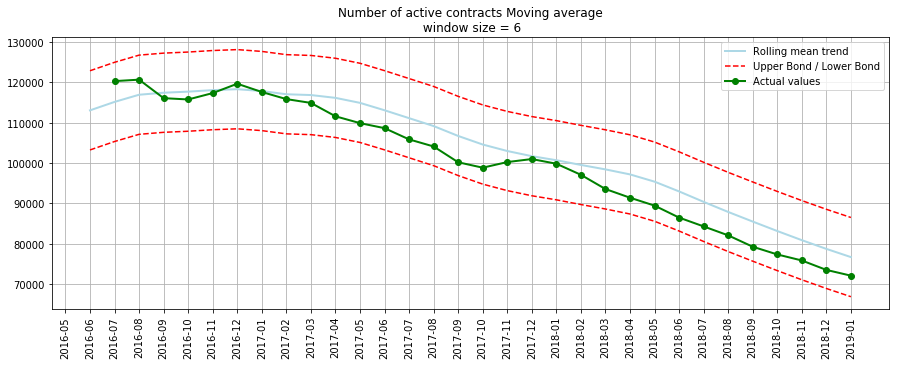

In [40]:
ds_ = pd.date_range('2016-01', '2019-01', freq='MS').strftime("%Y-%m").tolist()
y_ = [
    107778.0, 109994.0, 113108.0, 114177.0, 115098.0, 118306.0, 120326.0,
    120686.0, 116099.0, 115777.0, 117359.0, 119676.0, 117627.0, 115865.0,
    114920.0, 111605.0, 109906.0, 108660.0, 105876.0, 104116.0, 100202.0,
    98858.0, 100250.0, 101000.0, 99840.0, 97092.0, 93567.0, 91415.0, 89453.0,
    86481.0, 84296.0, 82079.0, 79260.0, 77345.0, 75847.0, 73510.0, 72084.0
]
df = pd.DataFrame({'ds': ds_, 'y': y_}).set_index('ds')

PlotMovingAverage(
    df,
    6,
    title_='Number of active contracts ',
    plot_intervals_=True,
    plot_anomalies_=True)

### Forecast (with visualization)

In [42]:
df_prophet = ProphetCover(df, 4, 'Number of active contracts', True, True,
                          True)

mean absolute error = 1.05%, mean squared error = 0.01%, mean absolute percentage error = 1.71%


## Cost of Claims

### Visualization

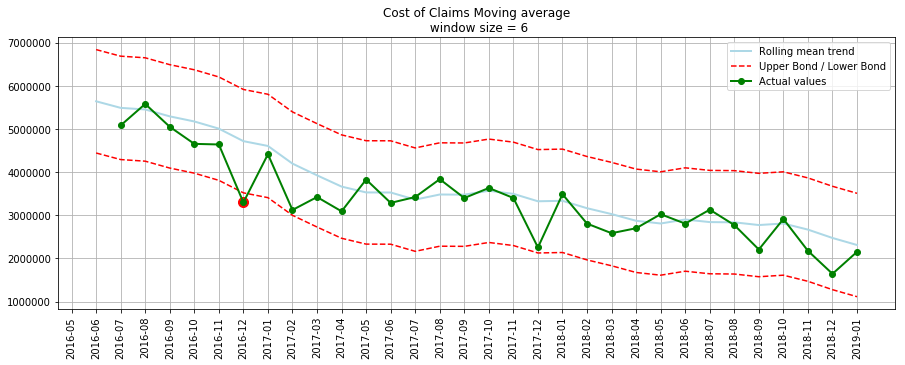

In [36]:
ds_ = pd.date_range('2016-01', '2019-01', freq='MS').strftime("%Y-%m").tolist()
y_ = [
    5993033.0, 5801763.0, 6004132.5, 5361492.0, 5637402.0, 5033809.5,
    5079910.0, 5577402.5, 5047820.0, 4652605.5, 4638360.5, 3296026.25,
    4412070.0, 3121070.5, 3420535.75, 3089713.0, 3825472.25, 3285342.75,
    3420716.0, 3834249.0, 3398034.5, 3630389.25, 3398544.0, 2252366.75,
    3486149.25, 2804878.5, 2582820.75, 2698253.75, 3022678.75, 2804982.25,
    3128099.5, 2771840.75, 2205137.5, 2912647.75, 2174333.25, 1641441.625,
    2151462.5
]
df = pd.DataFrame({'ds': ds_, 'y': y_}).set_index('ds')

PlotMovingAverage(
    df,
    6,
    title_='Cost of Claims ',
    plot_intervals_=True,
    plot_anomalies_=True)

### Forecast (with visualization and BoxCox transformation)

In [37]:
df_prophet = ProphetCover(df, 6, 'Cost of Claims', True, True, True)

INFO:fbprophet:n_changepoints greater than number of observations.Using 23.


mean absolute percentage error = 14.6%


INFO:fbprophet:n_changepoints greater than number of observations.Using 23.


mean absolute percentage error = 21.5%


## Claims Ratio

### Visualization

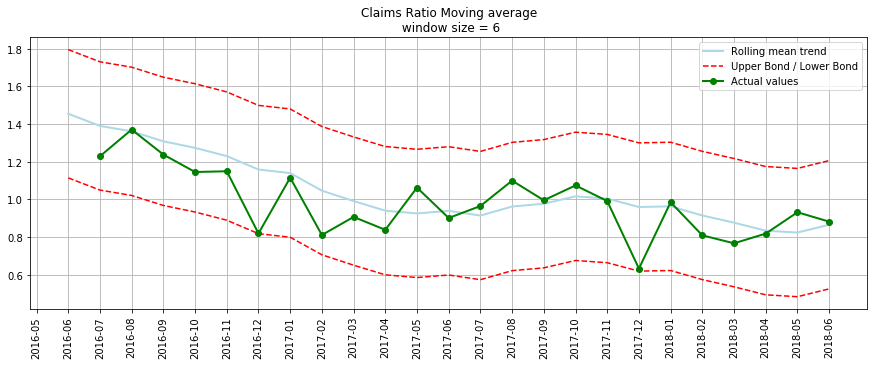

In [38]:
ds_ = pd.date_range('2016-01', '2018-06', freq='MS').strftime("%Y-%m").tolist()
y_ = [
    1.61802, 1.54237, 1.55733, 1.35447, 1.41088, 1.24814, 1.22923, 1.37104,
    1.23826, 1.14563, 1.14955, 0.819155, 1.11548, 0.810772, 0.90687, 0.838505,
    1.06264, 0.901214, 0.964954, 1.09966, 0.995444, 1.0743, 0.991349, 0.632517,
    0.984967, 0.809011, 0.766737, 0.818321, 0.931744, 0.881937
]

df = pd.DataFrame({'ds': ds_, 'y': y_}).set_index('ds')

PlotMovingAverage(
    df, 6, title_='Claims Ratio ', plot_intervals_=True, plot_anomalies_=True)
# df.head()

### Forecast (with visualization and BoxCox transformation)

In [39]:
df_prophet = ProphetCover(df, 6, 'Claim Ratio', True, True, False)
# df_prophet.head()

INFO:fbprophet:n_changepoints greater than number of observations.Using 18.


mean absolute error = 8.31%, mean squared error = 0.83%, mean absolute percentage error = 9.6%
